# Mixture of Experts (MoE) Transformer Training Notebook
 
This notebook provides a complete, reproducible implementation for training a Mixture of Experts (MoE) 
Transformer model inspired by the Llama4 architecture. It serves as a minimal working example, using a 
small dataset for demonstration and experimentation. The codebase is built from scratch for transparency 
and extensibility, with a focus on modularity, detailed expert routing analysis, and support for both 
random and top-k routing strategies.

## Overview
- **Author:** Tirth Shah
- **Inspired by:** [FareedKhan-dev/train-llama4](https://github.com/FareedKhan-dev/train-llama4)
- **Repository:** https://github.com/tsh-03/moe-experiments

## Features
- Modular implementation of a Transformer with MoE layers, supporting both random and top-k routing.
- Configurable number of experts, layers, and routing strategies.
- Includes utilities for training, evaluation, and visualization of routing and expert utilization 
  statistics.
- Supports multiple datasets, including a sample from *Alice's Adventures in Wonderland* and TinyStories.

## Usage
1. **Setup:** Ensure all dependencies and modules from this repository are available in your environment.
2. **Configuration:** Adjust model and training parameters in the notebook cells as needed.
3. **Training:** Run the notebook to train the MoE Transformer on your chosen dataset.
4. **Evaluation:** Analyze training curves and test loss. Generate text samples using the trained model. 
   A detailed analysis of routing entropy, expert utilization, and top-k accuracy is provided in 
   [moe-analyze.ipynb](./moe-analyze.ipynb).

## Structure
- **Data Preparation:** Utilities for loading and preprocessing datasets.
- **Model Definition:** MoE Transformer architecture and configuration.
- **Training Loop:** Training, loss tracking, and expert statistics logging.
- **Model Saving & Generation:** Save trained models and generate text samples.

## License
This project is licensed under the MIT License. See the [LICENSE](./LICENSE) file for details.

## Citation
If you use this codebase or notebook in your work, please cite the repository and acknowledge the 
original inspiration.

---

## Import Required Libraries and Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Import our custom modules
from model import MoETransformer, ModelConfig
from prepare_data import CharDataset, TinyStoriesDataset, sample_alice_text
from train import TrainModel, TrainConfig
import utils as utils

c:\Users\hetus\miniconda3\envs\moe-experiments\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set random seed for reproducibility

In [2]:
torch.manual_seed(42)

## Prepare Dataset

In [3]:
dataset_tag = 'tiny_stories'  # Choose dataset: 'sample_alice' or 'tiny_stories'

if dataset_tag == 'sample_alice':
    #--------- Sample text from Alice's Adventures in Wonderland ---------#
    # This is a small excerpt to keep the dataset manageable for testing and demonstration purposes.

    block_size = 64 # Define the block size for the dataset
    dataset = CharDataset(text=sample_alice_text, block_size=block_size) # Create dataset (tokenized with character tokenizer)

elif dataset_tag == 'tiny_stories':
    #--------- Tiny stories dataset ---------#
    # This dataset is a collection of short stories, which can be used for training language models.

    block_size = 64 # Define the block size for the dataset
    dataset = TinyStoriesDataset(block_size=block_size, max_samples=100000)  # Load the dataset (tokenized with tiktoken tokenizer)

else:
    raise ValueError("Invalid dataset_tag. Choose 'sample_alice' or 'tiny_stories'.")

TinyStoriesDataset loaded with 100000 stories and vocabulary size 17938


## Initialize MoE Transformer Model

In [4]:
# Model configuration
model_config = ModelConfig(
    dataset_tag=dataset_tag, # 'sample_alice', 'tiny_stories' are implemented; for other datasets, modify prepare_data.py
    d_model=64, # Embedding dimension
    n_layers=5, # Number of transformer layers
    n_heads=4, # Number of attention heads per layer
    block_size=block_size, # Context size for the model
    vocab_size=dataset.tokenizer.vocab_size, # Vocabulary size from the dataset
    num_local_experts=4, # Number of local experts in the MoE layer
    num_experts_per_tok=2, # Number of experts to route each token to
    intermediate_size_expert=128, # Size of the intermediate layer in each expert
    intermediate_size_shared=128, # Size of the intermediate layer in the shared expert of the MoE layer
    random_routing=False, # Use random routing if True, otherwise use top-k routing (useful as a sanity check to see whether intelligent routing really helps)
)

# Initialize the model
model = MoETransformer(config=model_config)
model = model.to(model.config.device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model initialized successfully!
Total parameters: 2,994,048
Trainable parameters: 2,994,048


## Training

Setting up training configuration

In [5]:
train_config = TrainConfig(
    learning_rate=1e-3, # fixed learning rate for AdamW optimizer
    batch_size=16, # Batch size for training
    steps=3000, # Number of training steps (1 training step = 1 batch passed through the model)
    print_interval=300, # Interval for printing training loss
    test_split=0.1 # Fraction of the dataset to be used for test loss computation
)

train_model = TrainModel(
    train_config=train_config,
    model=model,
    dataset=dataset,
)

Training the model

Starting training...


 10%|█         | 301/3000 [00:21<03:09, 14.25it/s]

Step 300/3000, Loss: 3.5979


 20%|██        | 603/3000 [00:41<02:39, 15.04it/s]

Step 600/3000, Loss: 3.0648


 30%|███       | 903/3000 [01:02<02:14, 15.59it/s]

Step 900/3000, Loss: 2.8049


 40%|████      | 1203/3000 [01:21<01:58, 15.20it/s]

Step 1200/3000, Loss: 2.7276


 50%|█████     | 1503/3000 [01:41<01:35, 15.65it/s]

Step 1500/3000, Loss: 2.6385


 60%|██████    | 1803/3000 [02:02<01:19, 14.96it/s]

Step 1800/3000, Loss: 2.6330


 70%|███████   | 2101/3000 [02:22<01:01, 14.53it/s]

Step 2100/3000, Loss: 2.3559


 80%|████████  | 2401/3000 [02:43<00:40, 14.97it/s]

Step 2400/3000, Loss: 2.4948


 90%|█████████ | 2703/3000 [03:03<00:19, 14.88it/s]

Step 2700/3000, Loss: 2.2829


100%|██████████| 3000/3000 [03:23<00:00, 14.77it/s]


Step 3000/3000, Loss: 2.6158


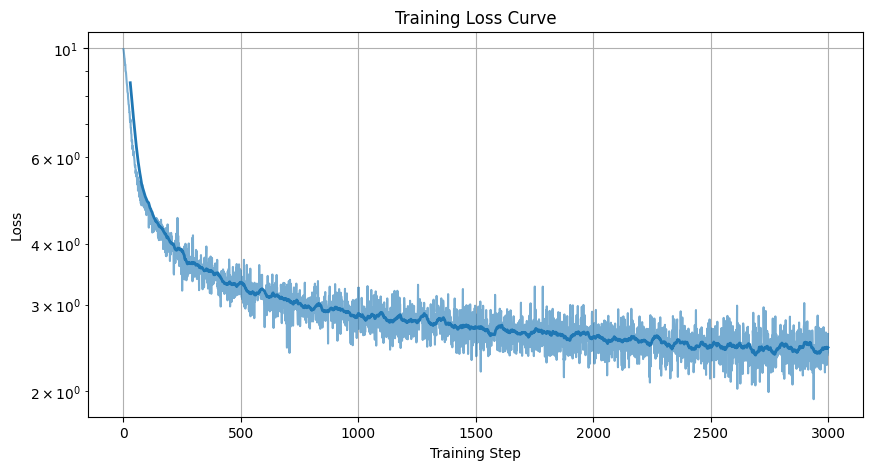

Training completed.
Final training loss: 2.6158


In [6]:
train_model.train()

print(f"Final training loss: {train_model.train_losses[-1]:.4f}")

Calculating test loss

In [7]:
test_loss = train_model.test_loss()

print(f"Test loss: {test_loss:.4f}")

Test loss: 2.4689


## Generate some text using the trained model

In [8]:
if dataset_tag == 'sample_alice':
    seed_text = "Alice"
elif dataset_tag == 'tiny_stories':
    seed_text = "Once upon a time"

model.generate(
    seed_text=seed_text,
    tokenizer=dataset.tokenizer,
    max_new_tokens=model_config.block_size,
)

Generation loop finished.


'Once upon a time there was a little boy who loved to jog all the time out he found a flute. At the hospital, he felt from the other old woman and was very happy. He lived in the week and wanted to play.\n\nOne day he arrived to the park to do something new. But his dad had a'

## Saving Model

In [9]:
utils.save_model(
    train_obj=train_model,
    # path=f"./saved_models/{dataset_tag}_random_routing_{model_config.random_routing}_top_{model_config.num_experts_per_tok}.pth",
    path=f"./saved_models/test.pth",
)

Model saved to ./saved_models/test.pth
